In [1]:
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

In [2]:
class PatchCraftTestDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []
        self.image_names = []

        categories = ["ai", "nature"]
        labels = {"ai": 1, "nature": 0}

        for category in categories:
            rich_dir = os.path.join(root_dir, category, "rich")
            poor_dir = os.path.join(root_dir, category, "poor")

            rich_images = sorted(os.listdir(rich_dir))
            poor_images = sorted(os.listdir(poor_dir))
            num_samples = min(len(rich_images), len(poor_images))

            for i in range(num_samples):
                rich_path = os.path.join(rich_dir, rich_images[i])
                poor_path = os.path.join(poor_dir, poor_images[i])
                self.samples.append((rich_path, poor_path, labels[category]))
                self.image_names.append(rich_images[i])

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        rich_path, poor_path, label = self.samples[idx]
        
        rich_img = Image.open(rich_path).convert("RGB")
        poor_img = Image.open(poor_path).convert("RGB")

        if self.transform:
            rich_img = self.transform(rich_img)
            poor_img = self.transform(poor_img)

        return torch.cat((rich_img, poor_img), dim=0), torch.tensor(label, dtype=torch.long), self.image_names[idx]

In [3]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

test_dataset = PatchCraftTestDataset(root_dir="data/processed_test/raw", transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

In [4]:
device = torch.device("cuda")

base_model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False)
base_model.conv1 = nn.Conv2d(6, 64, kernel_size=7, stride=2, padding=3, bias=False)
base_model.fc = nn.Linear(base_model.fc.in_features, 2)

model = base_model.to(device)
model.load_state_dict(torch.load("fine_tuned_patchcraft-baseline-patchcraft.pth"))
model.eval()

Using cache found in C:\Users\Kate/.cache\torch\hub\pytorch_vision_v0.10.0
C:\Users\Kate\miniconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Kate\miniconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\Kate\AppData\Local\Temp\ipykernel_14104\879256301.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details).

ResNet(
  (conv1): Conv2d(6, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [5]:
all_labels = []
all_preds = []
all_filenames = []

with torch.no_grad():
    for images, labels, filenames in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        predictions = torch.argmax(outputs, dim=1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predictions.cpu().numpy())
        all_filenames.extend(filenames)

In [6]:
print('Model accuracy: ', accuracy_score(all_labels, all_preds))
print('Model precision: ', precision_score(all_labels, all_preds))
print('Model recall: ', recall_score(all_labels, all_preds))

Model accuracy:  0.9761428571428571
Model precision:  0.966414777497901
Model recall:  0.9865714285714285


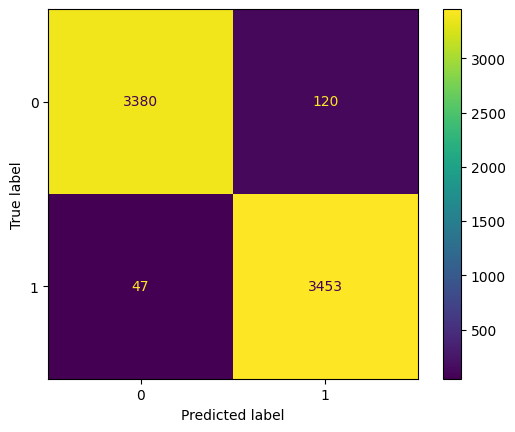

In [7]:
ConfusionMatrixDisplay(confusion_matrix(all_labels, all_preds)).plot()